# Import the libraries


In [1]:
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import shutil
import os

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


/home/mikhail/miniconda3/envs/catrecogai/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/mikhail/miniconda3/envs/catrecogai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-15 00:22:42.895864: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 00:22:42.905626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been reg

In [2]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


# Download the dataset


In [3]:
path = kagglehub.dataset_download("crawford/cat-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/mikhail/.cache/kagglehub/datasets/crawford/cat-dataset/versions/2


# Inspect the dataset

## List the files in the dataset directory


In [4]:
print("Files in the dataset directory:")
for folder in os.listdir(path):
    print(f"Folder {folder} has {len(os.listdir(os.path.join(path, folder)))} files ")

if 'data' not in os.listdir():
    os.mkdir("data")

Files in the dataset directory:
Folder CAT_02 has 0 files 
Folder CAT_03 has 0 files 
Folder CAT_00 has 0 files 
Folder CAT_06 has 0 files 
Folder CAT_05 has 0 files 
Folder CAT_04 has 0 files 
Folder CAT_01 has 0 files 


## Move the images and the .cat files in different folders


In [5]:
if 'images' not in os.listdir("data"):
    os.mkdir("data/images/no_category")
if 'cat_files' not in os.listdir("data"):
    os.mkdir("data/cat_files")

## Move the images and the .cat files in different folders


In [6]:
for folder in os.listdir(path):
    for file in os.listdir(os.path.join(path, folder)):
        if file.endswith(".cat"):
            shutil.move(os.path.join(path, folder, file), os.path.join("data/cat_files", file))
        else:
            shutil.move(os.path.join(path, folder, file), os.path.join("data/images/no_category", file))


In [7]:
## List the files in the images directory
print(f"The images directory has {len(os.listdir('data/images/no_category'))} files")
## List the files in the cat_files directory
print(f"The cat_files directory has {len(os.listdir('data/cat_files'))} files")

The images directory has 9993 files
The cat_files directory has 9993 files


## Data Loading

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [9]:
img_height = 150
img_width = 150
batch_size = 32

In [10]:
cat_folder = "data/images/no_category"

images = []

for filename in os.listdir(cat_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_path = os.path.join(cat_folder, filename)
        img = Image.open(img_path)
        img = img.resize((img_height, img_width))
        images.append(np.array(img))
images = np.array(images)
images = images.astype("float32") / 255.0

print(f"x_train shape: {images.shape}")

x_train shape: (9993, 150, 150, 3)


In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")

x_train shape: (7994, 150, 150, 3)
x_test shape: (1999, 150, 150, 3)


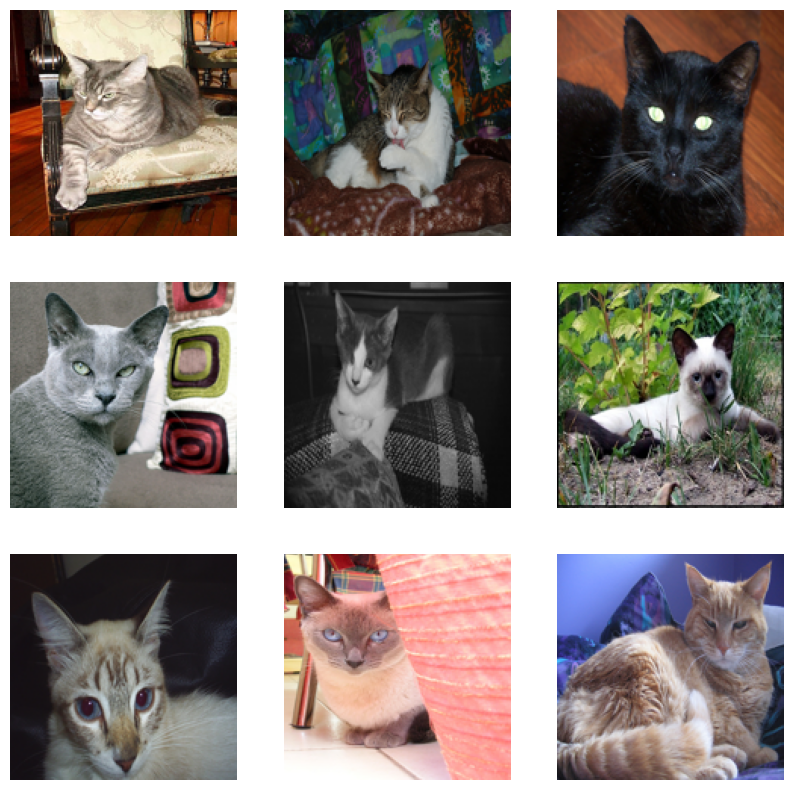

In [12]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i])
    plt.axis("off")
plt.show()

## Encoder

In [14]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    # Encoder
    self.encoder = tf.keras.Sequential([
      layers.Input(shape),  # Input shape: (150, 150, 3)
      layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  # Output shape: (150, 150, 32)
      layers.MaxPooling2D((2, 2), padding='same'),  # Output shape: (75, 75, 32)
      layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Output shape: (75, 75, 64)
      layers.MaxPooling2D((2, 2), padding='same'),  # Output shape: (38, 38, 64)
      layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # Output shape: (38, 38, 128)
      layers.MaxPooling2D((2, 2), padding='same'),  # Output shape: (19, 19, 128)
      layers.Conv2D(256, (3, 3), activation='relu', padding='same'),  # Output shape: (19, 19, 256)
      layers.MaxPooling2D((2, 2), padding='same'),  # Output shape: (10, 10, 256)
      layers.Flatten(),  # Output shape: (25600)
      layers.Dense(64),  # Output shape: (64)
    ])
    
    # Decoder
    self.decoder = tf.keras.Sequential([
      layers.Input(shape=(64,)),  # Input shape: (64)
      layers.Dense(25600, activation='relu'),  # Output shape: (25600)
      layers.Reshape((10, 10, 256)),  # Output shape: (10, 10, 256)
      layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),  # Output shape: (10, 10, 128)
      layers.UpSampling2D((2, 2)),  # Output shape: (20, 20, 128)
      layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),  # Output shape: (20, 20, 64)
      layers.UpSampling2D((2, 2)),  # Output shape: (40, 40, 64)
      layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),  # Output shape: (40, 40, 32)
      layers.UpSampling2D((2, 2)),  # Output shape: (80, 80, 32)
      layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same'),  # Output shape: (80, 80, 3)
      layers.UpSampling2D((2, 2)),  # Output shape: (160, 160, 3)
      layers.Cropping2D(cropping=((5, 5), (5, 5))),  # Output shape: (150, 150, 3)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = (img_height, img_width, 3)
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)

In [15]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder.h5',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

In [16]:
history = autoencoder.fit(x_train, x_train, 
                          epochs=50,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(x_test, x_test))

Epoch 1/50


I0000 00:00:1747261441.865627   72251 service.cc:152] XLA service 0x7f2604003890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747261441.865668   72251 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-05-15 00:24:01.930360: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747261442.113083   72251 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/250 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.6910

I0000 00:00:1747261447.507201   72251 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - loss: 0.6441 - val_loss: 0.5809
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.5773 - val_loss: 0.5636
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.5629 - val_loss: 0.5551
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.5544 - val_loss: 0.5494
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.5492 - val_loss: 0.5467
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.5463 - val_loss: 0.5453
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.5470 - val_loss: 0.5444
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.5445 - val_loss: 0.5451
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.5436 - val_loss: 0.5451
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.5439 - val_loss: 0.5440
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.5436 - val_loss: 0.5446
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/st

### Latent space visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


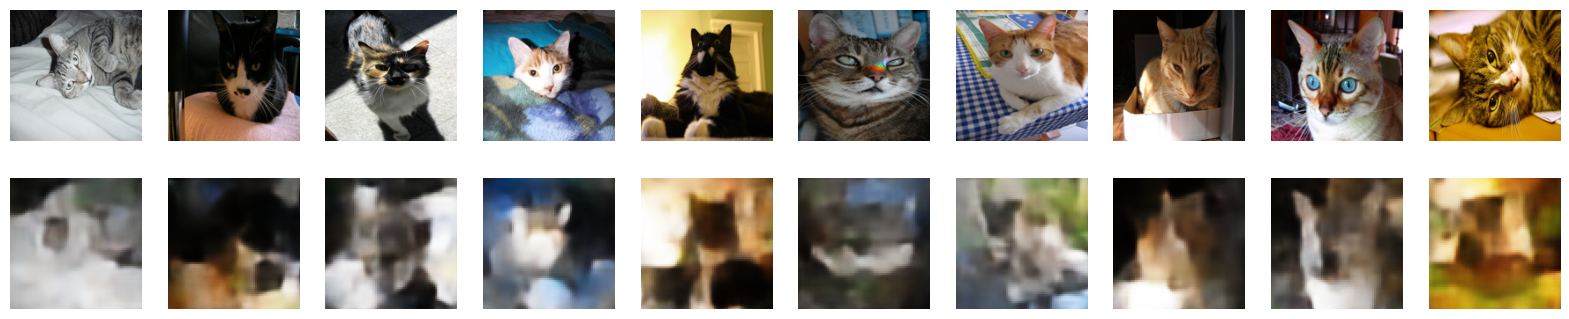

In [17]:
original_images = x_test[:10]
reconstructed_images = autoencoder.predict(original_images)

plt.figure(figsize=(20, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(original_images[i])
    plt.axis("off")

    # display reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(reconstructed_images[i])
    plt.axis("off")
plt.show()

## Clustering

# Model